<a href="https://colab.research.google.com/github/ptonydb/facial-expressions-classification/blob/main/pelios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

version_count = 3

TensorFlow 2.x selected.
2.0.0
2.2.4-tf


In [ ]:
import numpy

train_data = numpy.loadtxt(open('train_data.csv', 'rt'), delimiter=",")
train_target = numpy.loadtxt(open('train_target.csv', 'rt'), delimiter=",")
test_data = numpy.loadtxt(open('test_data.csv', 'rt'), delimiter=",")
#reshape each row to a proper 48x48x1 grayscale representation
train_data = train_data.reshape((16175,48,48,1))
#normalize 0-1
train_data = train_data.astype('float64') / 255
#do the same for test data since it follows the same format for our model
test_data = test_data.reshape((3965,48,48,1))
test_data = test_data.astype('float32') / 255


In [ ]:
print("\nTraining data")
print(train_data.shape)
print(train_data.ndim)
print(train_data.size)
print(train_data.dtype)
type(train_data)
print("\nTraining target")
print(train_target.shape)
print(train_target.ndim)
print(train_target.size)
print(train_target.dtype)
type(train_target)
print("\nTest data")
print(test_data.shape)
print(test_data.ndim)
print(test_data.size)
print(test_data.dtype)
type(test_data)


Training data
(16175, 48, 48, 1)
4
37267200
float64

Training target
(16175,)
1
16175
float64

Test data
(3965, 48, 48, 1)
4
9135360
float32


numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

print("\nTraining data")
print(X_train.shape)
print(X_train.ndim)
print(X_train.size)
print(X_train.dtype)
type(X_train)

print("\nValidation data")
print(X_valid.shape)
print(X_valid.ndim)
print(X_valid.size)
print(X_valid.dtype)
type(X_valid)


Training data
(12940, 48, 48, 1)
4
29813760
float64

Validation data
(3235, 48, 48, 1)
4
7453440
float64


numpy.ndarray

In [ ]:
model = tf.keras.models.Sequential()
#ZeroPadding for edge-cases data loss
#64 filters 3x3 with stride of 3
#max pooling and dropout for regularization
model.add(tf.keras.layers.ZeroPadding2D((1,1),input_shape=(48,48,1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(128, (5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()
## Compiling the model
# rmsprop seems to give me the best growth
model.compile(loss="sparse_categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_63 (ZeroPaddi (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
zero_padding2d_64 (ZeroPaddi (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 22, 22, 128)       204928    
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 11, 11, 128)     

In [ ]:
#augment the pictures within reasonable parameters
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                           zoom_range=0.1,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           shear_range=0.1,
                                                           horizontal_flip=True,
                                                           fill_mode="nearest")

BS = 256
epc = 250
history = model.fit_generator(data_aug.flow(X_train, y_train, batch_size=BS),
                              validation_data=(X_valid, y_valid), 
                              steps_per_epoch=len(X_train) // BS, 
                              epochs = epc)

Epoch 1/250
50/50 [==============================] - 15s 300ms/step - loss: 1.2288 - accuracy: 0.4380 - val_loss: 1.0686 - val_accuracy: 0.4485
Epoch 2/250
50/50 [==============================] - 15s 297ms/step - loss: 1.0699 - accuracy: 0.4461 - val_loss: 1.0639 - val_accuracy: 0.4485
Epoch 3/250
50/50 [==============================] - 15s 296ms/step - loss: 1.0596 - accuracy: 0.4421 - val_loss: 1.0399 - val_accuracy: 0.4550
Epoch 4/250
50/50 [==============================] - 15s 294ms/step - loss: 1.0328 - accuracy: 0.4692 - val_loss: 0.9631 - val_accuracy: 0.5422
Epoch 5/250
50/50 [==============================] - 15s 297ms/step - loss: 0.9898 - accuracy: 0.5161 - val_loss: 0.9062 - val_accuracy: 0.5889
Epoch 6/250
50/50 [==============================] - 15s 298ms/step - loss: 0.9023 - accuracy: 0.5824 - val_loss: 0.9346 - val_accuracy: 0.5641
Epoch 7/250
50/50 [==============================] - 15s 298ms/step - loss: 0.8390 - accuracy: 0.6165 - val_loss: 0.8251 - val_accuracy:

In [ ]:
# Training the model
#history = model.fit(X_train, y_train, epochs=30, batch_size = 32, validation_data=(X_valid, y_valid))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


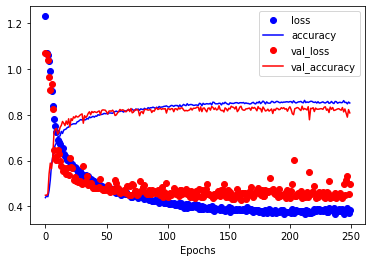

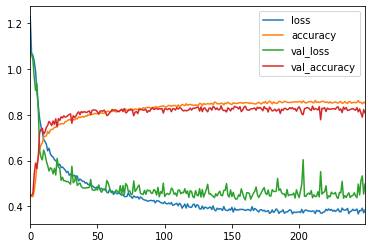

In [ ]:
# visualizing the learning curves
#The fit() method returns a History object containing the training parameters
#(history.params), the list of epochs it went through (history.epoch), and most
#importantly a dictionary (history.history) containing the loss and extra metrics it
#measured at the end of each epoch on the training set and on the validation set (if
#any). 

# (1) Obtain each track and plot
import matplotlib.pyplot as plt
epochs = range(epc)
print(history.history.keys())
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(epochs, train_loss, 'bo', label='loss')
plt.plot(epochs, train_acc, 'b-', label='accuracy')
plt.plot(epochs, val_loss, 'ro', label='val_loss')
plt.plot(epochs, val_acc, 'r-', label='val_accuracy')
plt.xlabel('Epochs')
#plt.ylabel('Performance')
plt.legend()

plt.show()

# (2) Use the pandas DataFrame and call its plot() method, 
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
#plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
predictions = model.predict(test_data)
predictions

array([[3.7393248e-01, 2.9884487e-02, 5.9618300e-01],
       [1.0000000e+00, 4.1190863e-13, 2.4689761e-10],
       [9.9856746e-01, 1.3859392e-03, 4.6508736e-05],
       ...,
       [1.1026110e-01, 7.3461705e-01, 1.5512185e-01],
       [1.1425845e-01, 1.8156713e-01, 7.0417440e-01],
       [2.3199204e-02, 6.1081845e-04, 9.7618991e-01]], dtype=float32)

In [ ]:
#get the biggest of three predictions and that will be the prediction for that row
predictions = numpy.argmax(predictions,axis=1)
predictions

array([2, 0, 0, ..., 1, 2, 2])

In [ ]:
#formatting output CSV file for submission
test_range = numpy.asarray(range(len(predictions)))
test_range = test_range.reshape(len(predictions),1)
predictions = predictions.reshape(len(predictions),1)
version_count = version_count + 1

In [ ]:
output = numpy.concatenate((test_range,predictions),axis=1)
numpy.savetxt("test_predictions_v{}.csv".format(version_count),output,delimiter=",",fmt=('%i','%i'),header="Id,Category",comments="")